In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features, plot_roc, boxplot_binary_predictions
from stabl.adaptive import ALasso, ALogitLasso
from stabl import data

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%config InlineBackend.figure_formats=['retina'] 

In [2]:
random_state = 42

lasso = Lasso(max_iter=int(1e6), random_state=random_state)
logit_lasso = LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", random_state=random_state)

alasso = ALasso(max_iter=int(1e6), random_state=random_state)
alogit_lasso = ALogitLasso(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", random_state=random_state)

en = ElasticNet(max_iter=int(1e6), random_state=random_state)
logit_en = LogisticRegression(penalty="elasticnet", max_iter=int(1e6), solver="saga", class_weight="balanced", random_state=random_state)

rf_regressor = RandomForestRegressor(random_state=random_state)
xgb_regressor = XGBRegressor(random_state=random_state)
rf_classifier = RandomForestClassifier(random_state=random_state)
xgb_classifier = XGBClassifier(random_state=random_state)

In [3]:
X_train_ool, X_valid_ool, y_train_ool, y_valid_ool, ids_ool, task_type_ool = data.load_onset_of_labor("Sample Data/Onset of Labor")
X_train_cov, X_valid_cov, y_train_cov, y_valid_cov, ids_cov, task_type_cov = data.load_covid_19("Sample Data/COVID-19")

preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),  # Removing 0 variance features
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
        ("imputer", SimpleImputer(strategy="median")),  # Imputing missing values with median
        ("std", StandardScaler())  # Z-scoring features
    ]
)

## Random Forest on On Labor Set

In [18]:
common_indices = X_train_ool["Proteomics"].index.intersection(y_train_ool.index)
common_features = X_train_ool["Proteomics"].columns.intersection(X_valid_ool["Proteomics"].columns)
X_train, y_train = X_train_ool["Proteomics"].loc[common_indices, common_features], y_train_ool[common_indices]

common_indices = X_valid_ool["Proteomics"].index.intersection(y_valid_ool.index)
X_valid, y_valid = X_valid_ool["Proteomics"].loc[common_indices, common_features], y_valid_ool[common_indices]

In [22]:
grid = {'max_depth': [2, 3, 4, 5]}

stabl_class = Stabl(
    base_estimator=clone(rf_regressor),
    lambda_grid=grid,
    artificial_type="knockoff",
    artificial_proportion=1,
    n_bootstraps=10,
    random_state=random_state,
    verbose=1,
)

overall_pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        ("feature_selection", stabl_class),
        ("final_model", RandomForestRegressor())
    ]
)

overall_pipe.fit(X_train, y_train)

Stabl progress:   0%|          | 0/4 [00:00<?, ?it/s]

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('variance_threshold',
                                  VarianceThreshold(threshold=0)),
                                 ('low_info_filter', LowInfoFilter()),
                                 ('imputer', SimpleImputer(strategy='median')),
                                 ('std', StandardScaler())])),
                ('feature_selection',
                 Stabl(artificial_proportion=1, artificial_type='knockoff',
                       base_estimator=RandomForestRegressor(random_state=42),
                       fdr_th...
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                       lambda_grid={'max_depth': [2, 3, 4, 5]}, n_bootstraps=10,
                       random_state=42, verbose=1)),
                ('final_model', RandomForestRegressor())])

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Threshold'>)

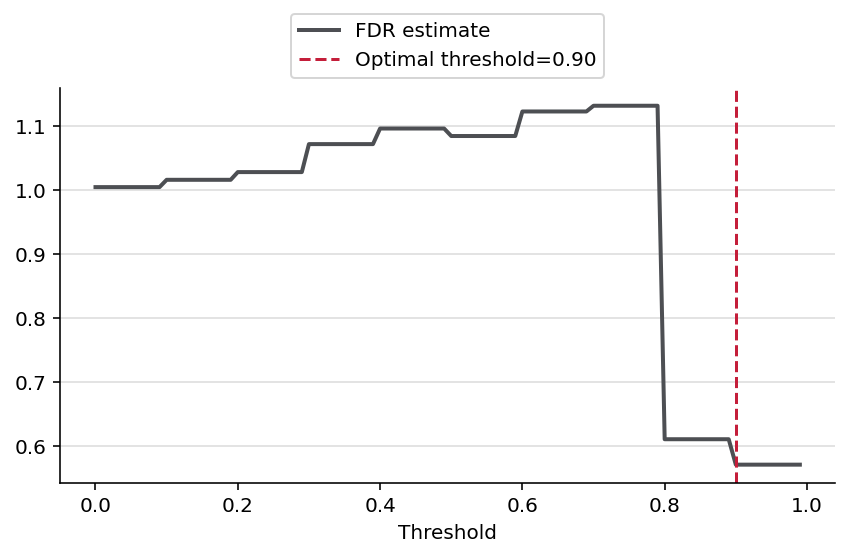

In [24]:
plot_fdr_graph(stabl_class, figsize=(6, 4))

(<Figure size 288x576 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>,
 [0.4, 0.6, 0.8, 1.0],
 [0, 1, 2, 3])

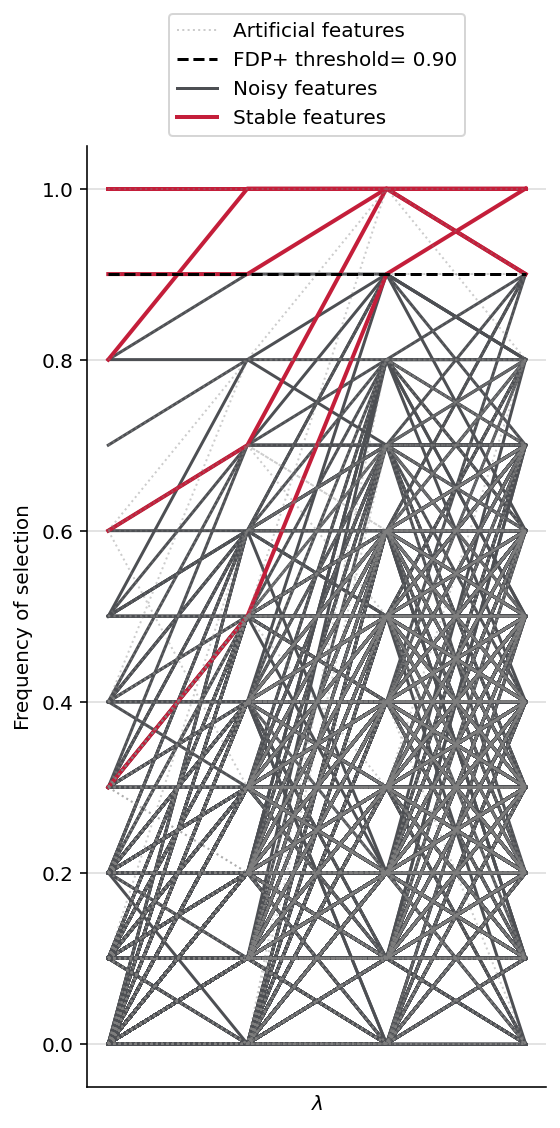

In [25]:
plot_stabl_path(stabl_class, figsize=(4,8))

In [35]:
# Get the 223rd feature
common_features[222]

'NovH'

In [38]:
stabl_class.get_feature_names_out()

array(['x223', 'x229', 'x739', 'x793', 'x838', 'x842', 'x1316'],
      dtype=object)

In [57]:
y_pred = overall_pipe.predict(X_train)
print("Training MSE:", np.mean((y_train - y_pred) ** 2))

y_pred = overall_pipe.predict(X_valid)
print("Validation MSE:", np.mean((y_valid - y_pred) ** 2))

Training MSE: 37.184315999999995
Validation MSE: 249.74584761904765


## XGBoost on COVID19

In [4]:
common_indices = X_train_cov["Proteomics"].index.intersection(y_train_cov.index)
common_features = X_train_cov["Proteomics"].columns.intersection(X_valid_cov["Proteomics"].columns)
X_train, y_train = X_train_cov["Proteomics"].loc[common_indices, common_features], y_train_cov[common_indices]

common_indices = X_valid_cov["Proteomics"].index.intersection(y_valid_cov.index)
X_valid, y_valid = X_valid_cov["Proteomics"].loc[common_indices, common_features], y_valid_cov[common_indices]

In [7]:
grid = {'max_depth': [3, 5], 'reg_lambda': [0.1, 1]}

stabl_class = Stabl(
    base_estimator=clone(xgb_classifier),
    lambda_grid=grid,
    artificial_type="knockoff",
    artificial_proportion=1,
    n_bootstraps=100,
    random_state=random_state,
    verbose=1,
)

overall_pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        ("feature_selection", stabl_class),
        ("final_model", XGBClassifier())
    ]
)

overall_pipe.fit(X_train, y_train)

Stabl progress:   0%|          | 0/4 [00:00<?, ?it/s]

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('variance_threshold',
                                  VarianceThreshold(threshold=0)),
                                 ('low_info_filter', LowInfoFilter()),
                                 ('imputer', SimpleImputer(strategy='median')),
                                 ('std', StandardScaler())])),
                ('feature_selection',
                 Stabl(artificial_proportion=1, artificial_type='knockoff',
                       base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    ca...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Threshold'>)

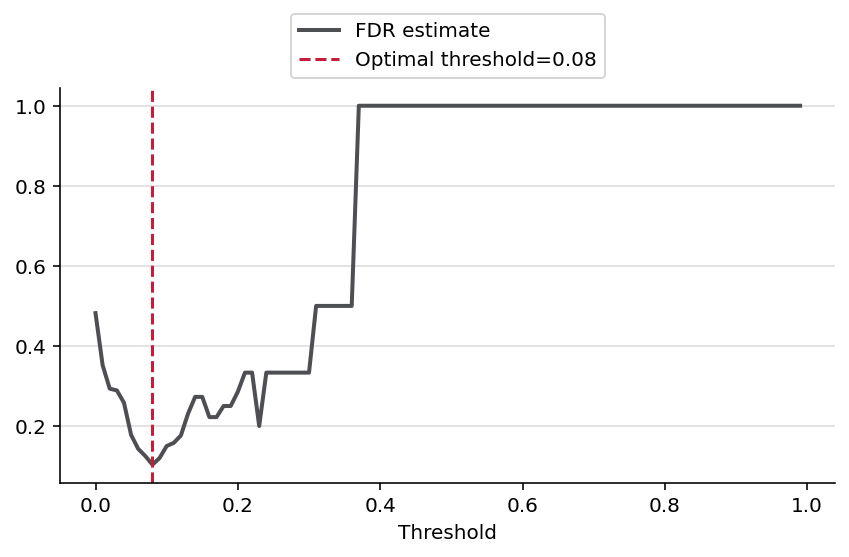

In [8]:
plot_fdr_graph(stabl_class, figsize=(6, 4))

(<Figure size 576x576 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>,
 [1.00001, 1.90001, 1.90002, 2.80002],
 [0, 1, 2, 3])

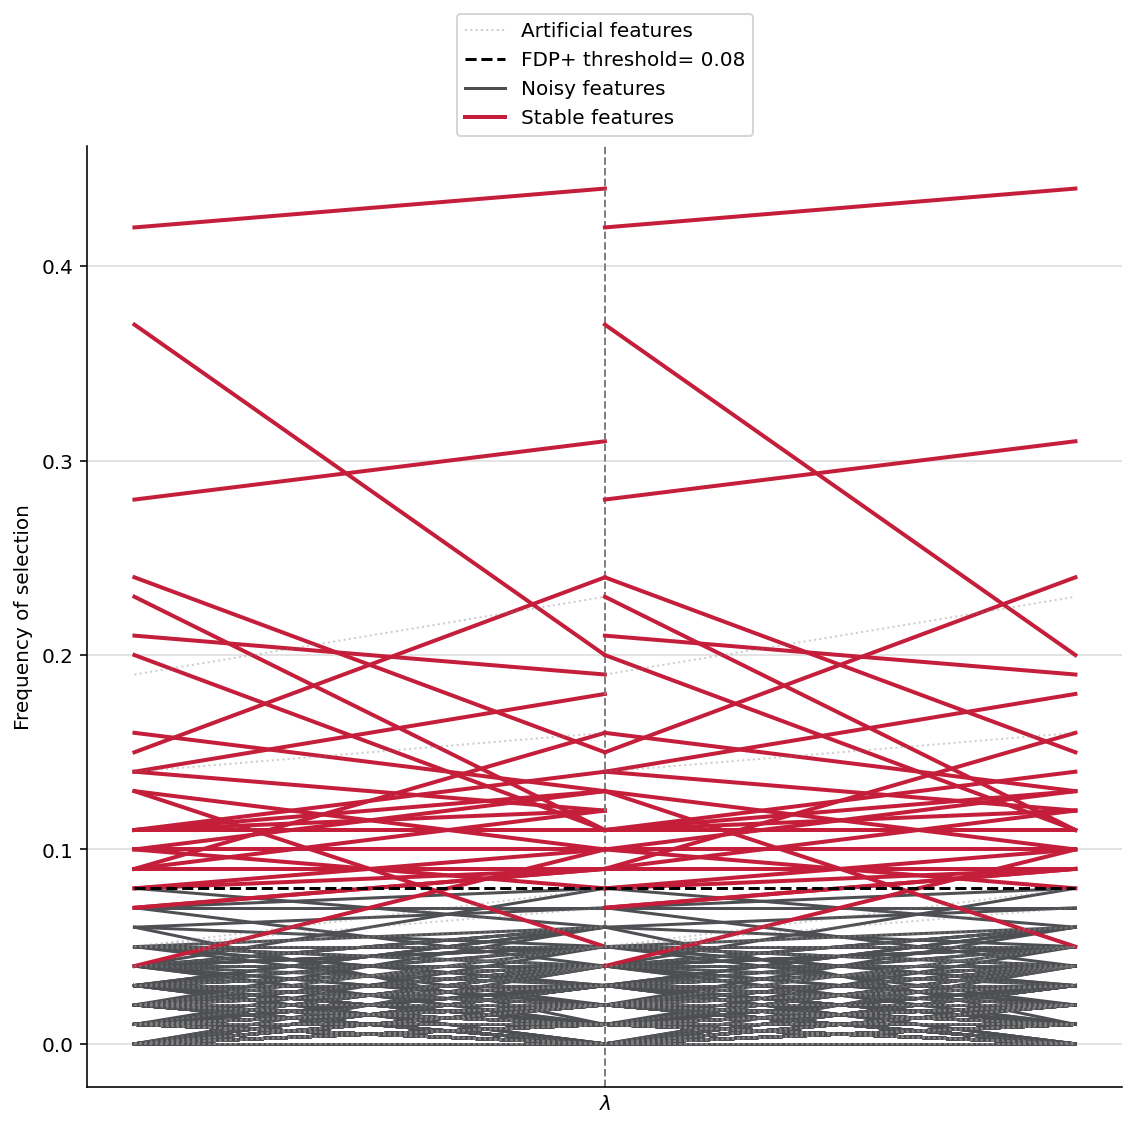

In [9]:
plot_stabl_path(stabl_class, figsize=(4,8))

In [12]:
stabl_class.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x15', 'x19', 'x21', 'x23', 'x160', 'x190', 'x371', 'x419', 'x572',
       'x594', 'x602', 'x715', 'x718', 'x755', 'x775', 'x909', 'x1032',
       'x1296'], dtype=object)

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='1 - Specificity', ylabel='Sensitivity'>)

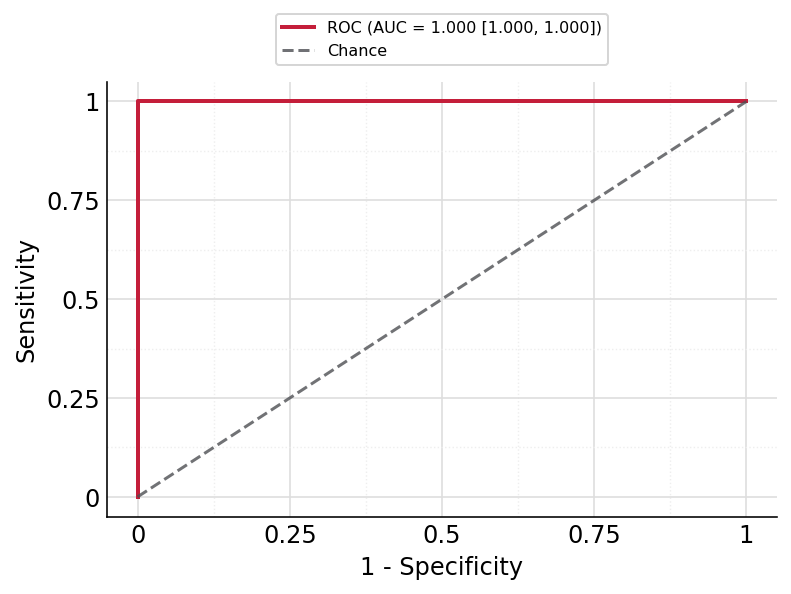

In [13]:
plot_roc(y_train, overall_pipe.predict_proba(X_train)[:,1])

(<Figure size 396x252 with 1 Axes>,
 <Axes: title={'center': '$\\bf{AUROC}$=1.00 [1.00, 1.00]\n$\\bf{AUPRC}$=1.00 [1.00, 1.00]'}, xlabel='Predictions', ylabel='Mild&ModVsSevere'>)

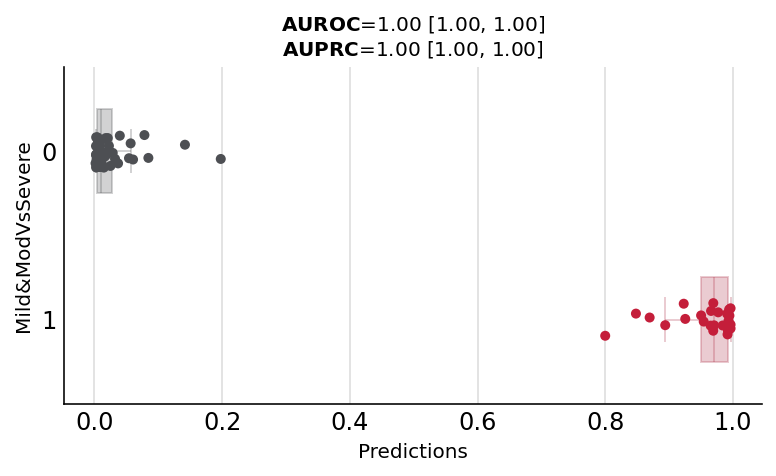

In [14]:
boxplot_binary_predictions(y_train, overall_pipe.predict_proba(X_train)[:,1])

In [15]:
y_valid_preds = overall_pipe.predict_proba(X_valid_cov["Proteomics"])[:,1]

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='1 - Specificity', ylabel='Sensitivity'>)

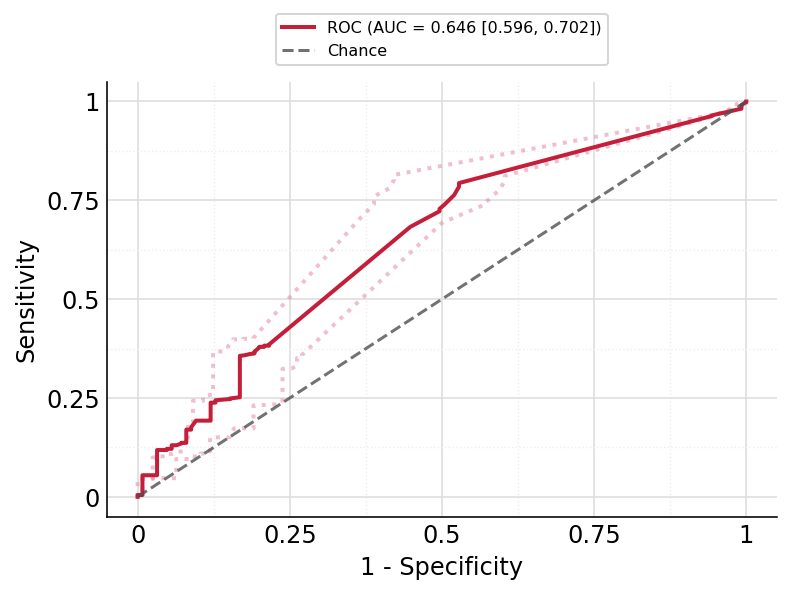

In [16]:
plot_roc(y_valid_cov, y_valid_preds)

(<Figure size 396x252 with 1 Axes>,
 <Axes: title={'center': '$\\bf{AUROC}$=0.65 [0.59, 0.70]\n$\\bf{AUPRC}$=0.90 [0.87, 0.92]'}, xlabel='Predictions', ylabel='WHO.0 ≥ 5'>)

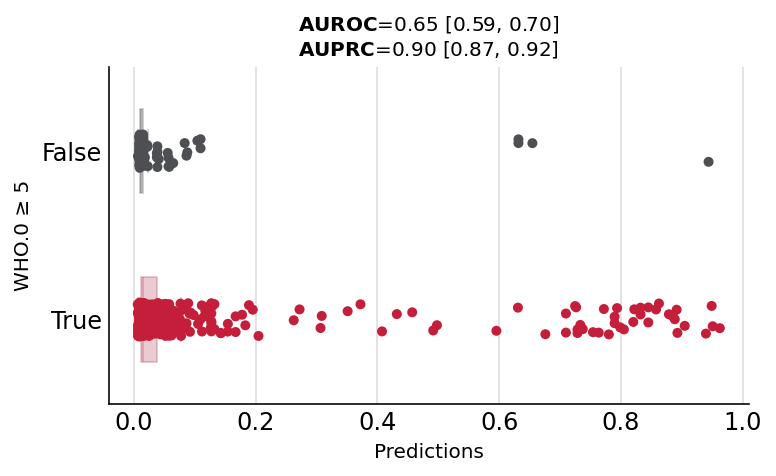

In [17]:
boxplot_binary_predictions(y_valid_cov, y_valid_preds)